In [203]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [204]:
def energy_functional(x, y, dy_dx):
    # Defines the energy functionalor aka the ODE/PDE based on the problem requirements. 
    # Here you can modify the functino yourself to match the energy function of your specific problem.
    # Like as an examle, if it's elasticity, you can use function of strain energy
    # Here, I defined a dummy function for simple demonstration.
    return 0.5 * (dy_dx ** 2) - 0.5 *  (y ** 2)  # Example: strain energy with linear potential that I found online.

In [205]:
x_range = (0.0, 10)  # Domain for the ODE
initial_conditions = [
    {'type': 'y', 'value': 1.0, 'x': 0.0},    # y(0) = 1
    {'type': 'y\'', 'value': 0.0, 'x': 0.0},  # y'(0) = 0
]
learning_rate = 0.001
num_epochs = 2000

In [206]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.hidden_layer_1 = nn.Linear(1, 200)
        self.hidden_layer_2 = nn.Linear(200, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)
        self.hidden_layer_4 = nn.Linear(200, 200)
        self.output_layer = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.sin(self.hidden_layer_1(x))
        x = torch.sin(self.hidden_layer_2(x))
        x = torch.sin(self.hidden_layer_3(x))
        x = self.output_layer(x)
        return x

In [207]:
def compute_energy_integral(net, x_range, num_points=1000):
    """Compute the integral of the energy functional over the specified x range."""
    x_min, x_max = x_range
    x = torch.linspace(x_min, x_max, num_points).view(-1, 1)
    x.requires_grad = True  
    
    y_pred = net(x)
    dy_dx_pred = torch.autograd.grad(y_pred, x, torch.ones_like(y_pred), create_graph=True)[0]
    
    energy_vals = energy_functional(x, y_pred, dy_dx_pred)
    
    integral = torch.mean(energy_vals) * (x_max - x_min)
    return integral ** 2

In [208]:
def apply_initial_conditions(net, initial_conditions):
    ivp_residuals = []
    for ivp in initial_conditions:
        x_ivp = torch.tensor([[ivp['x']]], requires_grad=True)
        y_ivp = net(x_ivp)
        
        if ivp['type'] == 'y':
            ivp_residual = y_ivp - ivp['value']
        elif ivp['type'] == 'y\'':
            dy_dx_ivp = torch.autograd.grad(y_ivp, x_ivp, torch.ones_like(x_ivp), create_graph=True)[0]
            ivp_residual = dy_dx_ivp - ivp['value']
        
        ivp_residuals.append(ivp_residual ** 2)
    
    return torch.sum(torch.stack([ivp**2 for ivp in ivp_residuals]))

In [209]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

def train(net, optimizer, x_range, initial_conditions, num_epochs):
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Compute the energy integral
        energy_integral = compute_energy_integral(net, x_range)

        # Apply initial condition residuals as constraints
        ivp_residual = apply_initial_conditions(net, initial_conditions)

        # Total loss: Energy integral + initial condition penalty
        loss = energy_integral + ivp_residual
        loss.backward()
        optimizer.step()
        # scheduler.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [210]:
net = Network()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

# Initialize the learning rate scheduler
step_size = 100  # Number of epochs after which to decay the learning rate
gamma = 0.1      # Multiplicative factor of learning rate decay
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, min_lr=1e-6)

In [211]:
train(net, optimizer, x_range, initial_conditions, num_epochs)

Epoch 0, Loss: 0.5663145184516907
Epoch 100, Loss: 7.160544100770494e-06
Epoch 200, Loss: 7.846809921829845e-07
Epoch 300, Loss: 2.939320324912842e-07
Epoch 400, Loss: 1.5119952934128378e-07
Epoch 500, Loss: 9.56088683778944e-08
Epoch 600, Loss: 6.997815660270135e-08
Epoch 700, Loss: 5.699785532442547e-08
Epoch 800, Loss: 5.0184567612632236e-08
Epoch 900, Loss: 4.6701334355248036e-08
Epoch 1000, Loss: 4.5133141668429744e-08
Epoch 1100, Loss: 4.469707803878009e-08
Epoch 1200, Loss: 4.490683380709015e-08
Epoch 1300, Loss: 4.5456900465978833e-08
Epoch 1400, Loss: 4.6145256504814824e-08
Epoch 1500, Loss: 4.685335497356391e-08
Epoch 1600, Loss: 4.7510123835081686e-08
Epoch 1700, Loss: 4.8086292281368515e-08
Epoch 1800, Loss: 4.858162228060792e-08
Epoch 1900, Loss: 4.9014175829142914e-08


In [212]:
def visualize_solution(net, x_range):
    x_min, x_max = x_range
    x_values = np.linspace(x_min, x_max, 100)
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)
    y_pred = net(x_tensor).detach().numpy()

    plt.plot(x_values, y_pred, label="DEM Solution")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Solution of the Harmonic Oscillator via DEM")
    plt.legend()
    plt.grid(True)
    plt.show()

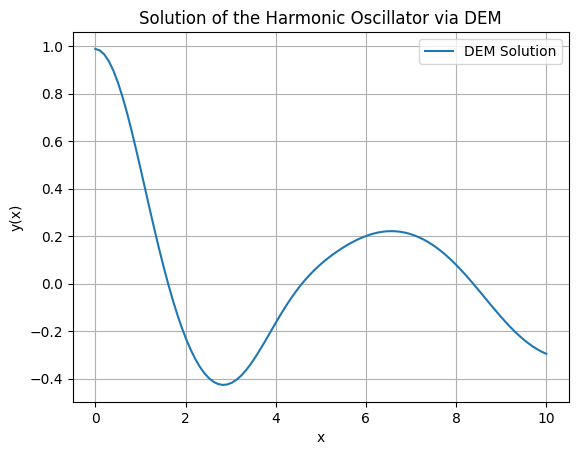

In [213]:
visualize_solution(net, x_range)